In [3]:
# imports 
import numpy as np 
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
import keras.backend as k_backend

import cv2
import imutils
import time

In [4]:
# data files 
base_path = "./../data/"
files = [os.path.join("{}{}".format(base_path,i)) for i in os.listdir(base_path) if os.path.exists("{}{}".format(base_path,i))]

In [5]:
 # get single sample and label from dataframe
def get_single_sample(df_sub):
    x1, x2, y1, y2 = df_sub["bbox_x1"], df_sub["bbox_x2"], df_sub["bbox_y1"], df_sub["bbox_y2"]
    xc, yc = (x1 + 2)/2, (y1+y2)/2
    width, height = x2 - x1 , y2 - y1
    r, g, b = df_sub["median_r"], df_sub["median_g"], df_sub["median_b"]
    h, s, v = df_sub["median_h"], df_sub["median_s"], df_sub["median_v"]
    stype = df_sub['type']
    sample = np.vstack( ( x1, x2, y1, y2, r, g, b, h, s, v, stype ) ).T 

    return sample


def get_single_label(df_label):
    x1, x2, y1, y2 = df_label["bbox_x1"], df_label["bbox_x2"], df_label["bbox_y1"], df_label["bbox_y2"]
    xc, yc = (x1 + 2)/2, (y1+y2)/2
    width, height = x2 - x1 , y2 - y1
    r, g, b = df_label["mean_r"], df_label["mean_g"], df_label["mean_b"]
    stype = df_label['type']
    label = np.vstack( ( x1, x2, y1, y2  ) ).T

    return label

In [6]:
# preprocessing

look_back = 4 # input time length
look_forward = 1 # output time length

x_dataset = []
y_dataset = []

for f in files: 
    
    df = pd.read_csv(f, sep='\t')

    if len(df) > look_back + look_forward: 

        for i in range( len(df) - look_back - look_forward ): 

            df_sub = df.iloc[i: i+look_back]
            df_label = df.iloc[i+look_back: i+look_back+look_forward]

            # train set
            sample = get_single_sample(df_sub)
            x_dataset.append( sample )

            # test set
            label = get_single_label(df_label)
            y_dataset.append(label)
            
# prepared dataset
x_dataset = np.array(x_dataset)
y_dataset = np.array(y_dataset)

print ("Total Data: ", x_dataset.shape, y_dataset.shape)

Total Data:  (1503, 4, 11) (1503, 1, 4)


In [7]:
# split train, test and validation sets 
n = x_dataset.shape[0] 

X_train, y_train = x_dataset[0 : int(0.7*n)], y_dataset[0 : int(0.7 * n)]
X_test, y_test = x_dataset[int(0.7*n) : int(0.9*n)], y_dataset[int(0.7 * n) : int(0.9*n)]
X_val, y_val = x_dataset[int(0.9*n) : ], y_dataset[int(0.9*n) : ]


print ("Train Dataset: ", X_train.shape, y_train.shape)
print ("Test Dataset: ", X_test.shape, y_test.shape)
print ("Validation Dataset: ", X_val.shape, y_val.shape)
print ("-"*50)

print ("Sample Train Dataset: ", X_train[0].shape, y_train[0].shape)
print ("Sample Test Dataset: ", X_test[0].shape, y_test[0].shape)
print ("Sample Validation Dataset: ", X_val[0].shape, y_val[0].shape)
print ("-"*50)

print ("Train Max/Min | Mean | Std.: ", np.max(X_train), np.min(X_train), np.mean(X_train), np.std(X_train),  )
print ("Test Max/Min | Mean | Std.: ", np.max(X_test), np.min(X_test), np.mean(X_test), np.std(X_test) )
print ("Val Max/Min | Mean | Std.: ", np.max(X_val), np.min(X_val), np.mean(X_val), np.std(X_val) )


Train Dataset:  (1052, 4, 11) (1052, 1, 4)
Test Dataset:  (300, 4, 11) (300, 1, 4)
Validation Dataset:  (151, 4, 11) (151, 1, 4)
--------------------------------------------------
Sample Train Dataset:  (4, 11) (1, 4)
Sample Test Dataset:  (4, 11) (1, 4)
Sample Validation Dataset:  (4, 11) (1, 4)
--------------------------------------------------
Train Max/Min | Mean | Std.:  1.0 0.0 0.46705902447718634 0.26834461481562333
Test Max/Min | Mean | Std.:  1.0 0.0 0.4691441993464052 0.26078293048907625
Val Max/Min | Mean | Std.:  1.0 0.0 0.4245342067441064 0.25402281437753693


In [8]:
# RMSE custom loss - not really used.
def root_mean_squared_error(y_true, y_pred):
    return k_backend.sqrt(k_backend.mean(k_backend.square(y_pred - y_true)))

In [9]:
# model 
n_features = X_train.shape[2]
n_neurons = 200
n_epochs = 250
n_out_features = y_train.shape[-1]

model = Sequential()
model.add( LSTM(n_neurons, input_shape=(look_back, n_features), return_sequences = True, name="lstm-1-layer")) 
model.add( LSTM(int(n_neurons/2), return_sequences = False  , activation = "relu", name = "lstm-2-layer") )
model.add( Dense(look_forward*n_out_features, activation = "sigmoid" , name = "dense-layer") )
model.add( Reshape([look_forward, n_out_features], name = "reshape-layer") )

opt = keras.optimizers.Adam(learning_rate=0.1)

# model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=['accuracy', 'mse', 'mae', root_mean_squared_error])
# model.compile(loss="mae", optimizer='adam', metrics=['accuracy', 'mse', 'mae'])
model.compile(loss="mse", optimizer='adam', metrics=['accuracy', 'mse', 'mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm-1-layer (LSTM)         (None, 4, 200)            169600    
                                                                 
 lstm-2-layer (LSTM)         (None, 100)               120400    
                                                                 
 dense-layer (Dense)         (None, 4)                 404       
                                                                 
 reshape-layer (Reshape)     (None, 1, 4)              0         
                                                                 
Total params: 290,404
Trainable params: 290,404
Non-trainable params: 0
_________________________________________________________________


In [10]:
# training 
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=50)

history = model.fit(
    x = X_train, y = y_train,
    epochs=n_epochs, 
    verbose=1,
    validation_data=(X_val, y_val),
    # callbacks=[early_stopping, reduce_lr],
    shuffle = False
)

Epoch 1/250


InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_7' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/home/arshad/tmp/ipykernel_4253/794436581.py", line 5, in <module>
      history = model.fit(
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/arshad/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/optimizers/optimizer.py", line 1245, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_7'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_7}}]] [Op:__inference_train_function_4930]

dict_keys(['loss', 'accuracy', 'mse', 'mae', 'val_loss', 'val_accuracy', 'val_mse', 'val_mae'])


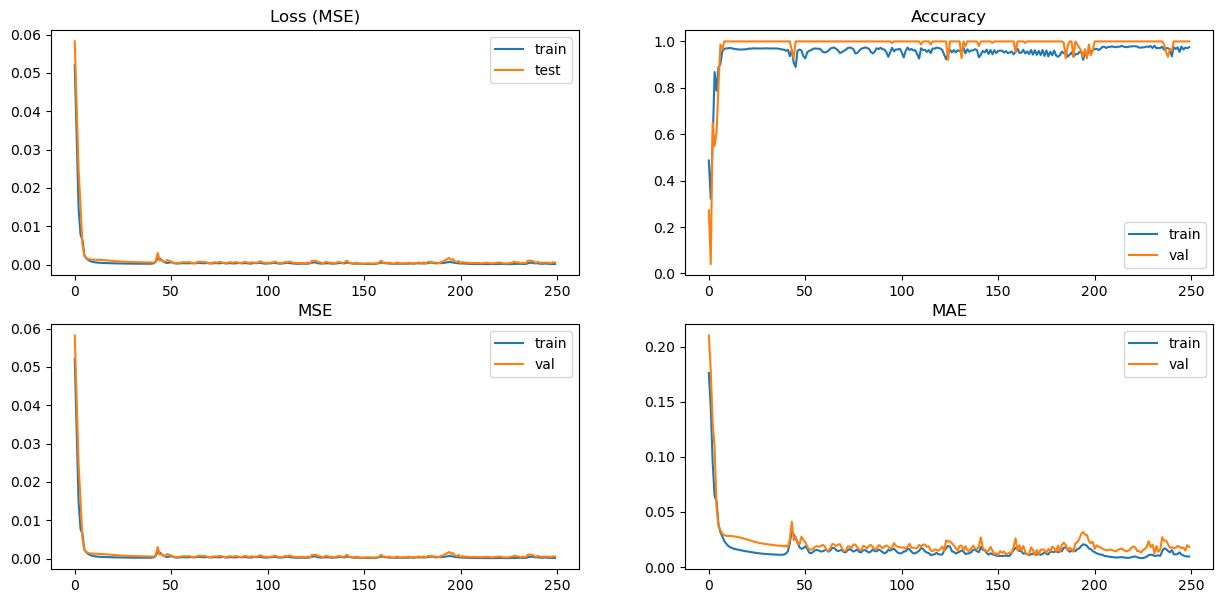

In [213]:
print (history.history.keys())
# plot model training history
plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Loss (MSE)")
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(2,2,3)
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='val')
plt.title("MSE")
plt.legend()

plt.subplot(2,2,4)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.title("MAE")
plt.legend()

plt.savefig("./rnn_{}}_lookback_{}_lookahead_{}_features_in_{}_features_out.png".format(look_back, look_forward, n_features, n_out_features))

plt.show()

In [214]:
# predictions
y_predictions  = model.predict(X_test)
print (y_predictions.shape, y_test.shape)

 1/10 [==>...........................] - ETA: 2s

2023-07-28 05:43:47.715133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 05:43:47.716015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 05:43:47.716995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 14ms/step
(300, 1, 4) (300, 1, 4)


In [215]:
# simple check
print ("Predicted: \n", y_predictions[0])
print ("-"*50)
print ("Real: \n", y_test[0])

Predicted: 
 [[0.4936152  0.51511294 0.44054613 0.48837632]]
--------------------------------------------------
Real: 
 [[0.465625   0.4953125  0.42916667 0.48333333]]


In [216]:
#evaluation metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef( np.squeeze(forecast), np.squeeze(actual) )[0,1]   # corr
    
    return({'mape':mape*100, 'me':me, 'mae': mae,  'rmse':rmse, 
            'corr':corr})


for i in range(n_out_features):
    out = (forecast_accuracy( y_predictions[:,:,i], y_test[:,:,i] ))
    print ("Feature : {}".format(i+1))
    print ("MAPE:\t", out["mape"], " %")
    print ("ME:\t", out["me"])
    print ("MAE:\t", out["mae"])
    print ("RMSE:\t", out["rmse"])
    print ("CORR:\t", out["corr"])
    print ("-----------")

Feature : 1
MAPE:	 37.661497136460866  %
ME:	 0.018657982554286717
MAE:	 0.018836314207563796
RMSE:	 0.02201851785026465
CORR:	 0.999041180667997
-----------
Feature : 2
MAPE:	 10.078234327209792  %
ME:	 0.022736638024449345
MAE:	 0.022909171973665553
RMSE:	 0.025761504200224813
CORR:	 0.9989891865924824
-----------
Feature : 3
MAPE:	 7.655144869247351  %
ME:	 -0.008217622091372804
MAE:	 0.014412201063500512
RMSE:	 0.01987266722541384
CORR:	 0.9965744617488042
-----------
Feature : 4
MAPE:	 5.02512804691813  %
ME:	 -0.0034547964781522777
MAE:	 0.014807313251826501
RMSE:	 0.019707940240709654
CORR:	 0.9959350438951022
-----------


(4, 11) (1, 4) (1, 4)


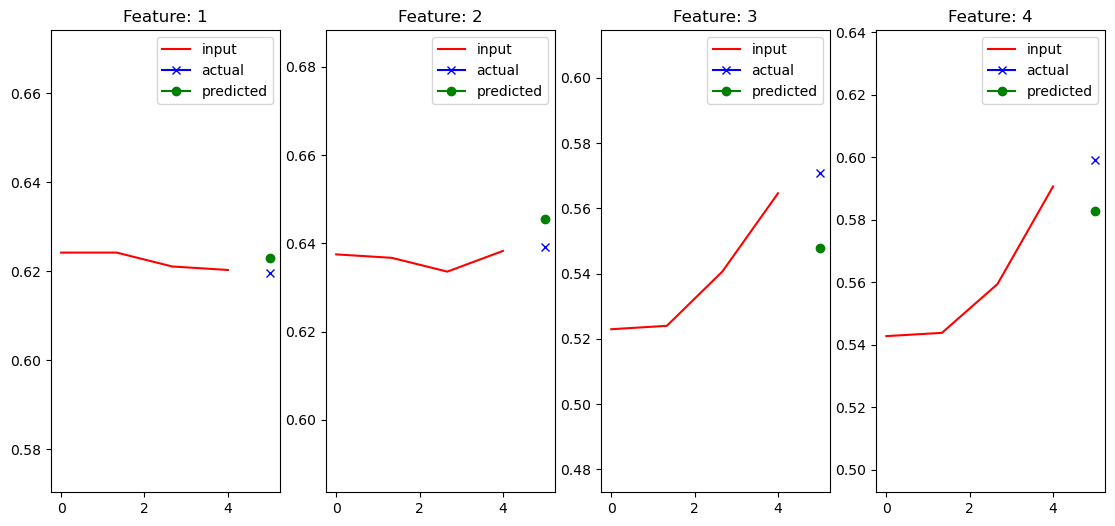

In [217]:
# test on random sets.
random_n = np.random.randint( X_test.shape[0]  )

test_y, label_y, predict_y = X_test[random_n], y_test[random_n], y_predictions[random_n]

test_x = np.linspace( 0, look_back , num = look_back )
label_x = np.arange( look_back + 1, look_forward + look_back + 1 , 1 )


plt.figure(figsize = (42, 6))
for i in range(n_out_features):
    plt.subplot(1, n_features+1, i+1)
    plt.plot(test_x, test_y[:, i] , '-r', label = "input" ) 
    plt.plot(label_x, label_y[:, i] , '-xb', label = "actual" )
    plt.plot(label_x, predict_y[:, i]  , '-og', label = "predicted" )
    plt.title("Feature: {}".format(i+1))
    plt.ylim([np.min(test_y[:,i]) - 0.05, np.max(test_y[:,i]) + 0.05 ])
    plt.legend()

plt.show()

44


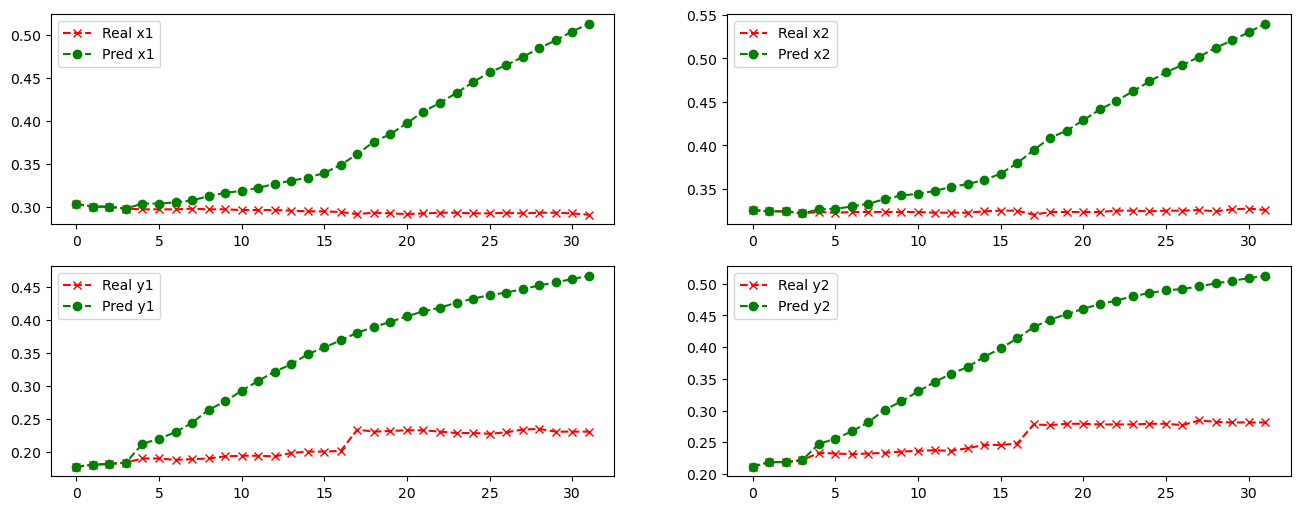

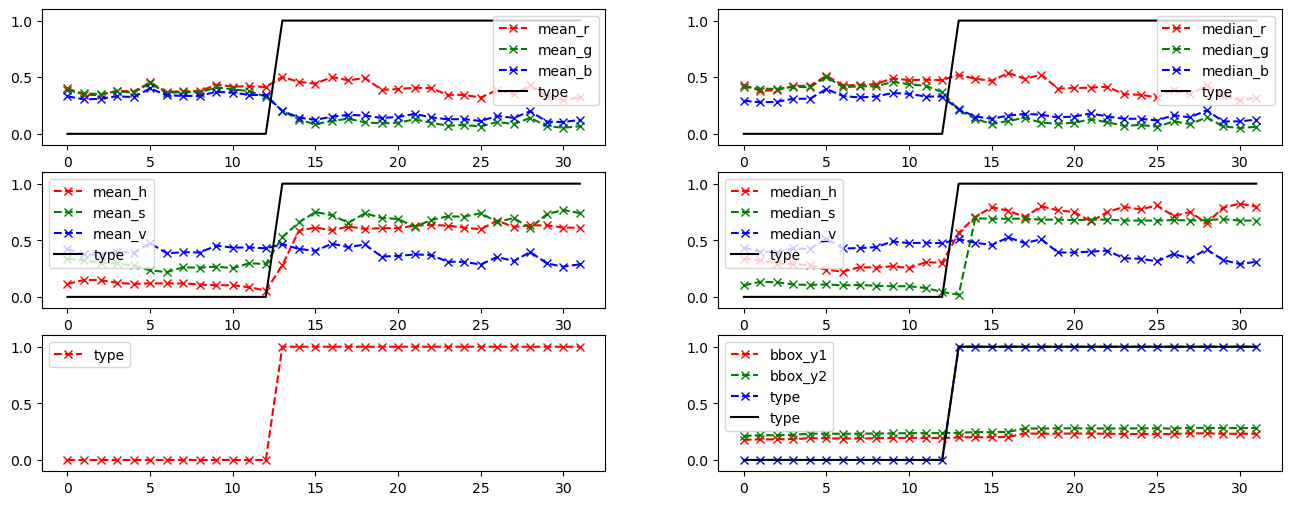

In [16]:
# This block takes a random file and 
# predicts the future bbox (x1, x2, y1, y2) 

# model.save ("./../../models/berry_lstm_in_feature_11_out_feature_4_look_back_4_look_ahead_1_n_epochs_250.h5")
# model = keras.models.load_model("./../../models/berry_lstm_in_feature_11_out_feature_4_look_back_4_look_ahead_1_n_epochs_250.h5")

# test on random sets.
random_n =  np.random.randint( len(files) )
df_sub = pd.read_csv(files[random_n], sep='\t')

# train set
sample = get_single_sample( df_sub )
sample_real = get_single_sample (df_sub)

predicted_values = []

for i in range(look_back):
    predicted_values.append([0,0,0,0])

for i in range(sample.shape[0] - look_back ):
    
    seq = sample[i : i + look_back]  
    y_predict = model.predict( np.expand_dims( seq , axis=0), verbose=0)  
    predicted_values.append( y_predict.squeeze().tolist() )

    # For teacher forcing. Otherwise comment this.
    sample[i+look_back, 0:4] = y_predict.squeeze().tolist()



# this plots predictions
predicted_values = np.array( predicted_values )
feature_names = ["x1", "x2", "y1", "y2"]

plt.figure(12, figsize=(16,6))
for i in range(n_out_features):

    plt.subplot(2,2,i+1)
    plt.plot( sample_real[:, i] , 'rx--', label="Real {}".format(feature_names[i]))

    # For teacher forcing. otherwise comment this.
    plt.plot( sample[:, i] , 'go--', label="Pred {}".format(feature_names[i]))

    # For normal prediction, 
    # plt.plot( predicted_values[:, i] , 'go--', label="Pred {}".format(feature_names[i]))
    plt.legend()

    # this gets used in the next block to visualize the predicted bbox.   
    df_sub['predicted_{}'.format(feature_names[i])] = predicted_values[:,i]


# this plots features 
other_features = [ 
    ['mean_r', 'mean_g','mean_b', 'type'], ['median_r', 'median_g','median_b', 'type'],
    ['mean_h', 'mean_s','mean_v', 'type'], ['median_h', 'median_s','median_v', 'type'],
    ['type'], [ 'bbox_y1', 'bbox_y2','type','type',] 
]

colors = ['rx--', 'gx--', 'bx--', 'k']

plt.figure(13, figsize=(16,6))

for i in range( len(other_features) ):

    if len(other_features) % 2 == 0:
        plt.subplot( int (len(other_features)/2) ,2 , i+1 )
    else:
        plt.subplot( len(other_features),1, i+1 )

    for count, feature in enumerate( other_features[i] ):
        plt.plot(  df_sub[ feature] , colors[count], label=feature )
        plt.legend()
        plt.ylim([-0.1,1.1])


In [14]:
# Correct the path 'img_folder'

img_folder = "/path/to/raw/images"

for i in range(len(df_sub)):
    row = df_sub.iloc[i]

    img_path = os.path.join( img_folder, "{}{}".format(row['filename'], '.png') )
    if os.path.exists(img_path):

        img = cv2.imread(img_path)
        img = imutils.resize(img, width = 640)
        h, w = img.shape[:2]

        # plot label
        x1, x2, y1, y2 = int(row['bbox_x1'] * w), int(row['bbox_x2'] * w), int (row['bbox_y1'] * h), int(row['bbox_y2'] * h)
        cv2.rectangle( img, (x1,y1), (x2, y2), (0, 0, 255), 2 )

        # plot label
        px1, px2, py1, py2 = int(row['predicted_x1'] * w), int(row['predicted_x2'] * w), int (row['predicted_y1'] * h), int(row['predicted_y2'] * h)
        cv2.rectangle( img, (px1,py1), (px2, py2), (0, 255, 0), 2 )
        
        cv2.imshow('image', img)
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break
        
        time.sleep(0.1)


cv2.destroyAllWindows()


QObject::moveToThread: Current thread (0x7aac1c0) is not the object's thread (0xa553b00).
Cannot move to target thread (0x7aac1c0)

QObject::moveToThread: Current thread (0x7aac1c0) is not the object's thread (0xa553b00).
Cannot move to target thread (0x7aac1c0)

QObject::moveToThread: Current thread (0x7aac1c0) is not the object's thread (0xa553b00).
Cannot move to target thread (0x7aac1c0)

QObject::moveToThread: Current thread (0x7aac1c0) is not the object's thread (0xa553b00).
Cannot move to target thread (0x7aac1c0)

QObject::moveToThread: Current thread (0x7aac1c0) is not the object's thread (0xa553b00).
Cannot move to target thread (0x7aac1c0)

QObject::moveToThread: Current thread (0x7aac1c0) is not the object's thread (0xa553b00).
Cannot move to target thread (0x7aac1c0)

QObject::moveToThread: Current thread (0x7aac1c0) is not the object's thread (0xa553b00).
Cannot move to target thread (0x7aac1c0)

QObject::moveToThread: Current thread (0x7aac1c0) is not the object's thread